# Time series clustering exercise

## TASKS:
    
    1. get and prep your data.
    2. cluster the NUMBER OF ESTABLISHMENTS time series with K-means
    in **a few** clusters (as discussed there is no real good, sound way to 
    decide what a good number is here. try a few options, keeping in mind 
    a few is more than a couple, but i recommand you stay within the 
    single digit numbers)
    
    3. plot the cluster centers (if you used K means those are the means of 
    the clusters). you can plot for example the cluster centers overlayed on 
    each time series (using the alpha channel to control the opacity in the 
    plot may be helpful here).
    
    4. Use another clustering algorithm (of your choice)
    
    5. overlay your data on a NYC map: you can use shapefiles for the 
    zip codes and different colors for different clusters
    
    6. Compare the results of the 2 algorithms
    
    7. attempt an interpretation. this is dangerous ground: clustering is 
    an exploratory tool so you do not want to jump to conclusions because 
    you see some clusters! but seeing structure in your data can inform 
    your next moves as an investigator. 
    

## Task 1

#### Imports

In [287]:
import os
import pandas as pd
import geopandas as gpd
import numpy as np 
# import matplotlib.pyplot as plt
import pylab as pl
import zipfile 
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
try:
    import urllib2 as urlib
except ImportError:
    import urllib as urlib
import requests
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['test']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [3]:
puidata = os.getenv("PUIDATA")
if puidata is None:
    os.environ["PUIDATA"] = "{}/Desktop/PUI/PUIDATA".format(os.getenv("HOME"))
#     os.environ["PUIDATA"] = "{}/PUIDATA".format(os.getenv("HOME"))
    puidata = os.getenv("PUIDATA")
    print("Warning: PUIDATA environmental variable not found and set by code, please review!")
print("PUIDATA: {}".format(puidata))

PUIDATA: /Users/soham/Desktop/PUI/PUIDATA


### Getting the data in

In [4]:
## Getting the zipcodes(borough_boundaries)
url = \
    'https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip'
filename = 'zipcodes.zip'
#Check if file exists
if not os.path.isfile(puidata + "/" + filename):
    print ("Downloading file")
    #Use this for some reason instead of curl, maybe because the url doesn't point to a file but generates it
    urlib.request.urlretrieve(url, filename)
    os.system("mv " + filename + " " + puidata)

#Unzip file
print ("Unzipping file")
os.system("unzip " + puidata + "/" + filename + " -d " + puidata + '/NYC_Zipcodes/')

#Get the file names from the .zip
files = os.popen("unzip -Z1 " + puidata + "/" + filename).read()
files = files.split(sep='\n')
shp_file = files[1]

if not os.path.isfile(puidata + "/NYC_Zipcodes/" + shp_file):
    print('Warning: file is not there, something went wrong!')
else:
    print('Files in place, please continue')

Unzipping file
Files in place, please continue


In [420]:
#Function for downloading data
def getBuraeuBizData(year):
    '''
        This is a function to download Buraeu Census Data from the repository of Professor Bianco 
        and load it in a pandas dataframe. 
    Arguments:
        year: The year for which the data is needed(2 digits)
    Return:
        Dataframe containing the data for the given year
    '''
    if len(str(year)) != 2: # Check input 
        print('Error: Enter appropriate year(2 digits)')
        return
    filename_zip = 'zbp{}totals.zip'.format(year)
    filename = 'zbp{}totals.txt'.format(year)
    # check for file
    if not os.path.isfile(puidata + "/" + filename):
        #Check zip
        if not os.path.isfile(puidata + "/" + filename_zip):
            #Download zip and move to puidata
            print ("Downloading file") 
            os.system("curl -L -O " +
                "https://github.com/fedhere/PUI2018_fb55/raw/master/HW12_fb55/" +\
                     filename_zip )#+ "?raw=true >" + filename_zip)
            # move to puidata
            os.system("mv " + filename_zip + " " + puidata) #+ "/BuraeuBiz/")
        # Unzipping into a dataframe
        print ("Unzipping file") 
        zf = zipfile.ZipFile(puidata + "/" + filename_zip)

    df = pd.read_csv(zf.open(filename_zip.replace('.zip','.txt')))
    if df.empty: 
        print('Error: Unable to unzip correctly into a dataframe. Please check.')
        return()
    return(df)



In [7]:
nyczipsshp = gpd.read_file(os.getenv("PUIDATA") + "/NYC_Zipcodes/ZIP_CODE_040114.shp")
print("ZIPCODES:",
      len(np.unique(nyczipsshp.ZIPCODE)), "POLYGONS:",
      len(nyczipsshp.ZIPCODE),
      "the difference is due to island with same zip as parts of land,",
      "but disjoint shapes")
nyczips = nyczipsshp.ZIPCODE.values.astype(int)
print("number of NYC zip codes:", len(nyczips))

ZIPCODES: 248 POLYGONS: 263 the difference is due to island with same zip as parts of land, but disjoint shapes
number of NYC zip codes: 263


In [8]:
nyczipsshp.head()

,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry
0,11436,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,0.0,0.0,"POLYGON ((1038098.251871482 188138.3800067157,..."
1,11213,0,Brooklyn,62426.0,2.963100e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1001613.712964058 186926.4395172149,..."
2,11212,0,Brooklyn,83866.0,4.197210e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1011174.275535807 183696.33770971, 1..."
3,11225,0,Brooklyn,56527.0,2.369863e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((995908.3654508889 183617.6128015518,..."
4,11218,0,Brooklyn,72280.0,3.686880e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((991997.1134308875 176307.4958601296,..."


In [9]:
nyczipsshp.ZIPCODE = nyczipsshp.ZIPCODE.astype('int')

In [10]:
cbs = getBuraeuBizData('00') # Initializing the dataframe

Unzipping file


In [11]:
cbs.head()

,ZIP,NAME,EMPFLAG,EMP,QP1,AP,EST
0,501,"HOLTSVILLE, NY",A,0,0,0,1
1,1001,"AGAWAM, MA",NaN,8042,59833,259661,493
2,1002,"AMHERST, MA",NaN,6547,36719,169658,563
3,1003,"AMHERST, MA",NaN,82,308,2482,13
4,1004,"AMHERST, MA",NaN,717,2049,5826,48


In [12]:
# doing an initial merge with the zipcodes and dropping the unnecessary columns
cbs = nyczipsshp.merge(cbs,how='left',left_on = 'ZIPCODE',right_on = 'ZIP')[['ZIPCODE','geometry','EST']]
cbs.rename({'EST':'EST00'},axis=1,inplace=True)

In [13]:
cbs.head()

,ZIPCODE,geometry,EST00
0,11436,"POLYGON ((1038098.251871482 188138.3800067157,...",65.0
1,11213,"POLYGON ((1001613.712964058 186926.4395172149,...",477.0
2,11212,"POLYGON ((1011174.275535807 183696.33770971, 1...",520.0
3,11225,"POLYGON ((995908.3654508889 183617.6128015518,...",417.0
4,11218,"POLYGON ((991997.1134308875 176307.4958601296,...",1161.0


In [14]:
LowerCase = [3,4,5,6,7,8,9]
UpperCase = [98,99]

In [15]:
# Getting all the files in using multiple single loops
for i in range(1,10):
    print('0'+str(i))
    if i in LowerCase:
        cbs = cbs.merge(getBuraeuBizData('0'+str(i)),how='left',left_on = 'ZIPCODE'\
                    ,right_on = 'zip')
#         cbs.drop(cbs.iloc[:,len(cbs.columns)-7:len(cbs.columns)-1],axis=1,inplace=True)
        cbs.rename({'est':'EST{}'.format('0'+str(i))},axis=1,inplace=True)
    else:
        cbs = cbs.merge(getBuraeuBizData('0'+str(i)),how='left',left_on = 'ZIPCODE'\
                    ,right_on = 'ZIP')
        cbs.rename({'EST':'EST{}'.format('0'+str(i))},axis=1,inplace=True)

for i in range(10,15):
    print(i)
    cbs = cbs.merge(getBuraeuBizData(str(i)),how='left',left_on = 'ZIPCODE'\
                    ,right_on = 'zip')
    cbs.rename({'est':'EST{}'.format(str(i))},axis=1,inplace=True)

for i in range(94,100):
    print(i)
    if i in UpperCase:
        cbs = cbs.merge(getBuraeuBizData(str(i)),how='left',left_on = 'ZIPCODE'\
                    ,right_on = 'ZIP')
        cbs.rename({'EST':'EST{}'.format(str(i))},axis=1,inplace=True)
    else:
        cbs = cbs.merge(getBuraeuBizData(str(i)),how='left',left_on = 'ZIPCODE'\
                    ,right_on = 'zip')
        cbs.rename({'est':'EST{}'.format(str(i))},axis=1,inplace=True)
    

01
Unzipping file
02
Unzipping file
03
Unzipping file
04
Unzipping file
05
Unzipping file
06
Unzipping file
07
Unzipping file
08
Unzipping file
09
Unzipping file
10
Unzipping file
11
Unzipping file
12
Unzipping file
13
Unzipping file
14
Unzipping file
94
Unzipping file
95
Unzipping file
96
Unzipping file
97
Unzipping file
98
Unzipping file
99
Unzipping file


In [16]:
cbs.head()

,ZIPCODE,geometry,EST00,ZIP_x,NAME_x,EMPFLAG_x,EMP_x,QP1_x,AP_x,EST01,...,QP1_x,AP_x,EST98,ZIP_y,NAME_y,EMPFLAG_y,EMP_y,QP1_y,AP_y,EST99
0,11436,"POLYGON ((1038098.251871482 188138.3800067157,...",65.0,11436.0,"JAMAICA, NY",NaN,1099.0,4787.0,23387.0,57.0,...,2730.0,12233.0,51.0,11436.0,"JAMAICA, NY",NaN,673.0,2987.0,13658.0,58.0
1,11213,"POLYGON ((1001613.712964058 186926.4395172149,...",477.0,11213.0,"BROOKLYN, NY",NaN,4121.0,31824.0,135498.0,493.0,...,34696.0,144293.0,476.0,11213.0,"BROOKLYN, NY",NaN,4050.0,26729.0,119603.0,473.0
2,11212,"POLYGON ((1011174.275535807 183696.33770971, 1...",520.0,11212.0,"BROOKLYN, NY",NaN,9060.0,73718.0,312117.0,527.0,...,79868.0,334713.0,519.0,11212.0,"BROOKLYN, NY",NaN,10074.0,74717.0,325361.0,541.0
3,11225,"POLYGON ((995908.3654508889 183617.6128015518,...",417.0,11225.0,"BROOKLYN, NY",NaN,3173.0,17222.0,77224.0,422.0,...,15570.0,69267.0,416.0,11225.0,"BROOKLYN, NY",NaN,3165.0,16033.0,68930.0,409.0
4,11218,"POLYGON ((991997.1134308875 176307.4958601296,...",1161.0,11218.0,"BROOKLYN, NY",NaN,10365.0,61446.0,243619.0,1180.0,...,45565.0,209737.0,1118.0,11218.0,"BROOKLYN, NY",NaN,9711.0,50115.0,223674.0,1149.0


### Preparing the data

In [68]:
to_keep = ['ZIPCODE','geometry']

In [69]:
for i in range(94,100):
    to_keep.append('EST'+str(i)) 

In [70]:
for i in range(0,10):
    to_keep.append('EST'+'0'+str(i)) 

In [71]:
for i in range(10,15):
    to_keep.append('EST'+str(i)) 

In [72]:
to_keep

['ZIPCODE',
 'geometry',
 'EST94',
 'EST95',
 'EST96',
 'EST97',
 'EST98',
 'EST99',
 'EST00',
 'EST01',
 'EST02',
 'EST03',
 'EST04',
 'EST05',
 'EST06',
 'EST07',
 'EST08',
 'EST09',
 'EST10',
 'EST11',
 'EST12',
 'EST13',
 'EST14']

In [73]:
cbs = cbs[to_keep]

In [421]:
# sanity check of df by head() and shape
cbs.head()

,ZIPCODE,geometry,EST94,EST95,EST96,EST97,EST98,EST99,EST00,EST01,...,EST05,EST06,EST07,EST08,EST09,EST10,EST11,EST12,EST13,EST14
0,11436,"POLYGON ((1038098.251871482 188138.3800067157,...",51.0,50.0,53.0,51.0,51.0,58.0,65.0,57.0,...,82.0,80.0,84.0,90.0,92.0,98.0,101.0,95.0,99.0,109.0
1,11213,"POLYGON ((1001613.712964058 186926.4395172149,...",406.0,420.0,433.0,456.0,476.0,473.0,477.0,493.0,...,556.0,565.0,556.0,592.0,621.0,675.0,674.0,726.0,755.0,772.0
2,11212,"POLYGON ((1011174.275535807 183696.33770971, 1...",505.0,494.0,502.0,527.0,519.0,541.0,520.0,527.0,...,587.0,570.0,587.0,602.0,647.0,699.0,713.0,721.0,731.0,752.0
3,11225,"POLYGON ((995908.3654508889 183617.6128015518,...",381.0,387.0,388.0,410.0,416.0,409.0,417.0,422.0,...,491.0,499.0,514.0,520.0,543.0,580.0,597.0,623.0,673.0,696.0
4,11218,"POLYGON ((991997.1134308875 176307.4958601296,...",985.0,1015.0,1049.0,1075.0,1118.0,1149.0,1161.0,1180.0,...,1332.0,1331.0,1377.0,1397.0,1457.0,1474.0,1523.0,1605.0,1687.0,1736.0


In [423]:
# 20 years of data and 263 zipcodes
cbs.shape

(263, 23)

In [424]:
# Wrangling the data so that the columns have only the number of establishments per year and the index zipcodes
cleancsb = cbs.dropna() 
cleancsb.index = cleancsb.ZIPCODE
cleancsb.drop(['ZIPCODE','geometry'],axis=1,inplace=True)

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [77]:
#cleaning all missing values
cleancsb.shape

(243, 21)

In [78]:
#then the standardization will look like:
vals = ((cleancsb.T - cleancsb.mean(1)) / cleancsb.std(1)).T


## Task-2

In [394]:
#cluster with kmeans
nc1 = 4
km4 = KMeans(n_clusters=nc1, random_state=444).fit(vals)


In [395]:
km4.labels_.shape

(243,)

In [396]:
centres = km.cluster_centers_

In [397]:
vals_clustered = vals.copy()

In [398]:
vals_clustered['labels'] = km4.labels_

In [399]:
vals_clustered_with_geom = vals_clustered.merge(cbs[['ZIPCODE','geometry']],on='ZIPCODE',how='left')

## Task 3 & 5

### The map of the clusters may look something like this

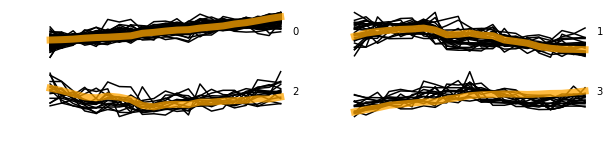

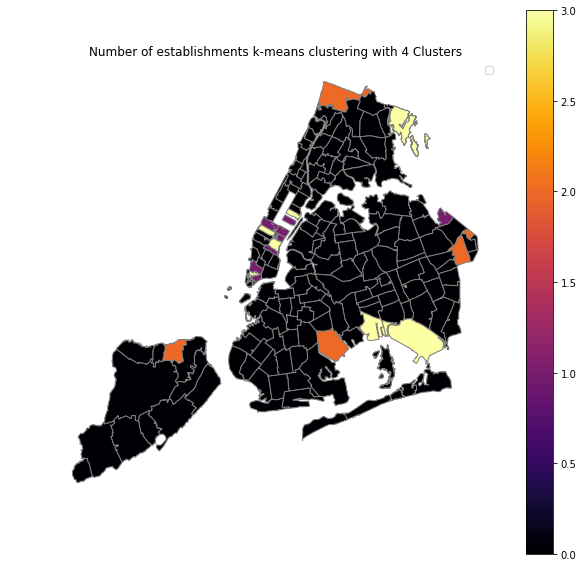

In [409]:
fig = plt.figure(figsize=(10,2))


for i in range(0,4):
    a = vals_clustered.loc[vals_clustered['labels']==i].iloc[:,:len(vals_clustered.columns)-1]
    ax = fig.add_subplot(221+i)
    ax.axis('off')
    ax.annotate('{}'.format(i),xy=(1,1),xytext=(1, 0.5),textcoords='axes fraction')
    for index,row in a.iterrows():
        plt.plot(range(len(vals_clustered.columns)-1),row,c='black')
    plt.plot(range(len(vals_clustered.columns)-1),centres[i],c='orange',lw=7,alpha=0.75)
    

fig,ax = plt.subplots(figsize=(10,10))
vals_clustered_with_geom.plot(column='labels',ax=ax,  edgecolor='grey',  cmap='inferno',legend=True)
plt.title('Number of establishments k-means clustering with 4 Clusters')
ax.axis('off')
ax.legend(['0','1','2','3'])


#Correct aspect ratio
# ax.axes.set_aspect('equal')

plt.show()

### Figure 1: The clustered business pattern time series as well as the cloropleth of  cluster centers for 4 k-means clusters of business patterns (number of businesses) at the zipcode level for NYC have been plotted here. Each color indicates a cluster in the cloropleth. The data used here is the yearly Census Buraeu Business data from 1994 to 2014 which is 21 years. The cluster classes seem to be highly imbalanced as most of the zipcodes lie in cluster 0. Cluster 0 has an increasing trend which makes sense as most areas have seen growth in businesses over the years. Cluster 1 has areas like lower manhattan and Central Park and has been seeing a slight decrease in the same. There are a few zipcodes in cluster 2 from all the boroughs except Manhattan and there all seem to be in areas which might be less populous as the number of businesses is also more or less stagnant globally. Cluster 3 shows area like JFK and Penn Station which have seen an increase over the years.

#### Trying another value of k

In [401]:
#cluster with kmeans
nc2 = 5
km5 = KMeans(n_clusters=nc2, random_state=444).fit(vals)


In [402]:
#each observation in the km object has a label: 
#that is the cluster assigned to that observation
km5.labels_.shape

(243,)

In [403]:
centres = km5.cluster_centers_

In [404]:
vals_clustered_2 = vals.copy()

In [405]:
vals_clustered_2['labels'] = km5.labels_

In [406]:
vals_clustered_with_geom_2 = vals_clustered_2.merge(cbs[['ZIPCODE','geometry']],on='ZIPCODE',how='left')

### The map of the clusters may look something like this

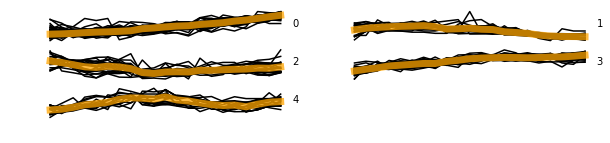

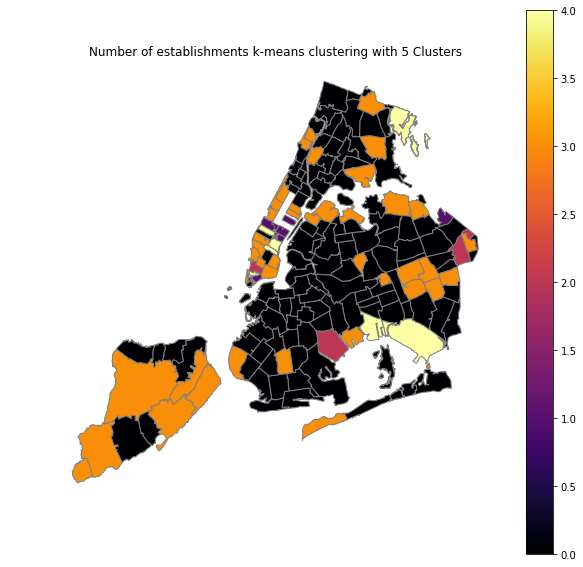

In [408]:
fig = plt.figure(figsize=(10,2))


for i in range(0,5):
    a = vals_clustered_2.loc[vals_clustered_2['labels']==i].iloc[:,:len(vals_clustered_2.columns)-1]
    ax = fig.add_subplot(321+i)
    ax.axis('off')
    ax.annotate('{}'.format(i),xy=(1,1),xytext=(1, 0.5),textcoords='axes fraction')
    for index,row in a.iterrows():
        plt.plot(range(len(vals_clustered_2.columns)-1),row,c='black')
    plt.plot(range(len(vals_clustered_2.columns)-1),centres[i],c='orange',lw=7,alpha=0.75)
    

fig,ax = plt.subplots(figsize=(10,10))
vals_clustered_with_geom_2.plot(column='labels',ax=ax,  edgecolor='grey',  cmap='inferno',legend=True)
plt.title('Number of establishments k-means clustering with 5 Clusters')
ax.axis('off')
# ax.legend(['0','1','2','3'])


#Correct aspect ratio
# ax.axes.set_aspect('equal')

plt.show()

### Figure 2: The clustered business pattern time series as well as the cloropleth of  cluster centers for 5 k-means clusters of business patterns (number of businesses) at the zipcode level for NYC have been plotted here. Each color indicates a cluster in the cloropleth. The data used here is the yearly Census Buraeu Business data from 1994 to 2014 which is 21 years. The cluster classes seem to be better distributed than above as most of them don't belong to any single cluster. Cluster 0 has an increasing trend which makes sense as most of the areas seem to be areas in the other brorughs except Manhattan developed recently and have seen growth in businesses over the years. Cluster 1 has areas surrounding  Central Park and has been seeing a slight decrease in the same. There are a few zipcodes in cluster 2 from Lower Manhattan, Brooklyn and Queens and the number of businesses have shown a slight decrease. Cluster 3 has areas from all boroughs just like 0 and have an increase in the number over the years. Cluster 4 shows area like JFK and Penn Station where the number of businesses have been slightly increasing over the years.

# If you want to use agglomerative clustering

## Task 4

In [361]:
nc = 5
agc = AgglomerativeClustering(n_clusters=nc, linkage='average').fit(vals)
agc.labels_.shape

(243,)

In [358]:
vals_clustered_agc = vals.copy()

In [362]:
vals_clustered_agc['labels'] = agc.labels_

In [363]:
agc.get_params()

{'affinity': 'euclidean',
 'compute_full_tree': 'auto',
 'connectivity': None,
 'linkage': 'average',
 'memory': None,
 'n_clusters': 5,
 'pooling_func': <function numpy.core.fromnumeric.mean(a, axis=None, dtype=None, out=None, keepdims=<class 'numpy._globals._NoValue'>)>}

In [364]:
vals_clustered_with_geom_agc = vals_clustered_agc.merge(cbs[['ZIPCODE','geometry']],on='ZIPCODE',how='left')

### The map of the clusters may look something like this

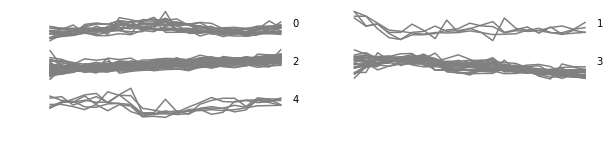

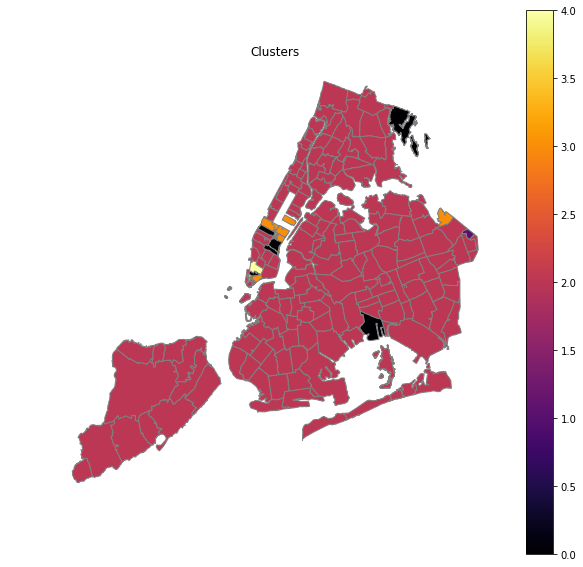

In [427]:
fig = plt.figure(figsize=(10,2))


for i in range(0,5):
    a = vals_clustered_agc.loc[vals_clustered_agc['labels']==i].iloc[:,:len(vals_clustered_agc.columns)-1]
    ax = fig.add_subplot(321+i)
    ax.axis('off')
    ax.annotate('{}'.format(i),xy=(1,1),xytext=(1, 0.5),textcoords='axes fraction')
    for index,row in a.iterrows():
        plt.plot(range(len(vals_clustered_agc.columns)-1),row,c='grey')
#     plt.plot(range(len(vals_clustered_2.columns)-1),centres[i],c='orange',lw=7,alpha=0.75)
    

fig,ax = plt.subplots(figsize=(10,10))
vals_clustered_with_geom_agc.plot(column='labels',ax=ax,edgecolor='grey',cmap='inferno',legend=True)
plt.title('Clusters')
ax.axis('off')
# ax.legend(['0','1','2','3'])


#Correct aspect ratio
# ax.axes.set_aspect('equal')

plt.show()

### Figure 3: The clustered business pattern time series as well as the cloropleth of  cluster centers for 5 agglomerative clusters of business patterns (number of businesses) at the zipcode level for NYC have been plotted here. Each color indicates a cluster in the cloropleth. The data used here is the yearly Census Buraeu Business data from 1994 to 2014 which is 21 years. The cluster classes seem to be highly imbalanced as most are in cluster 2 which covers most of the city and has a stagnant to slightly increasing trend. In the rest, what stands out is cluster 3 which has the areas around Central Park and a zipcode in the outskirts of Queens and shows a decreasing trend. The rest are very small groups and quite stagnant to draw any inferences.

### And if you use hierarchical clustering in scipy you can make a dandrogram it may look like this:

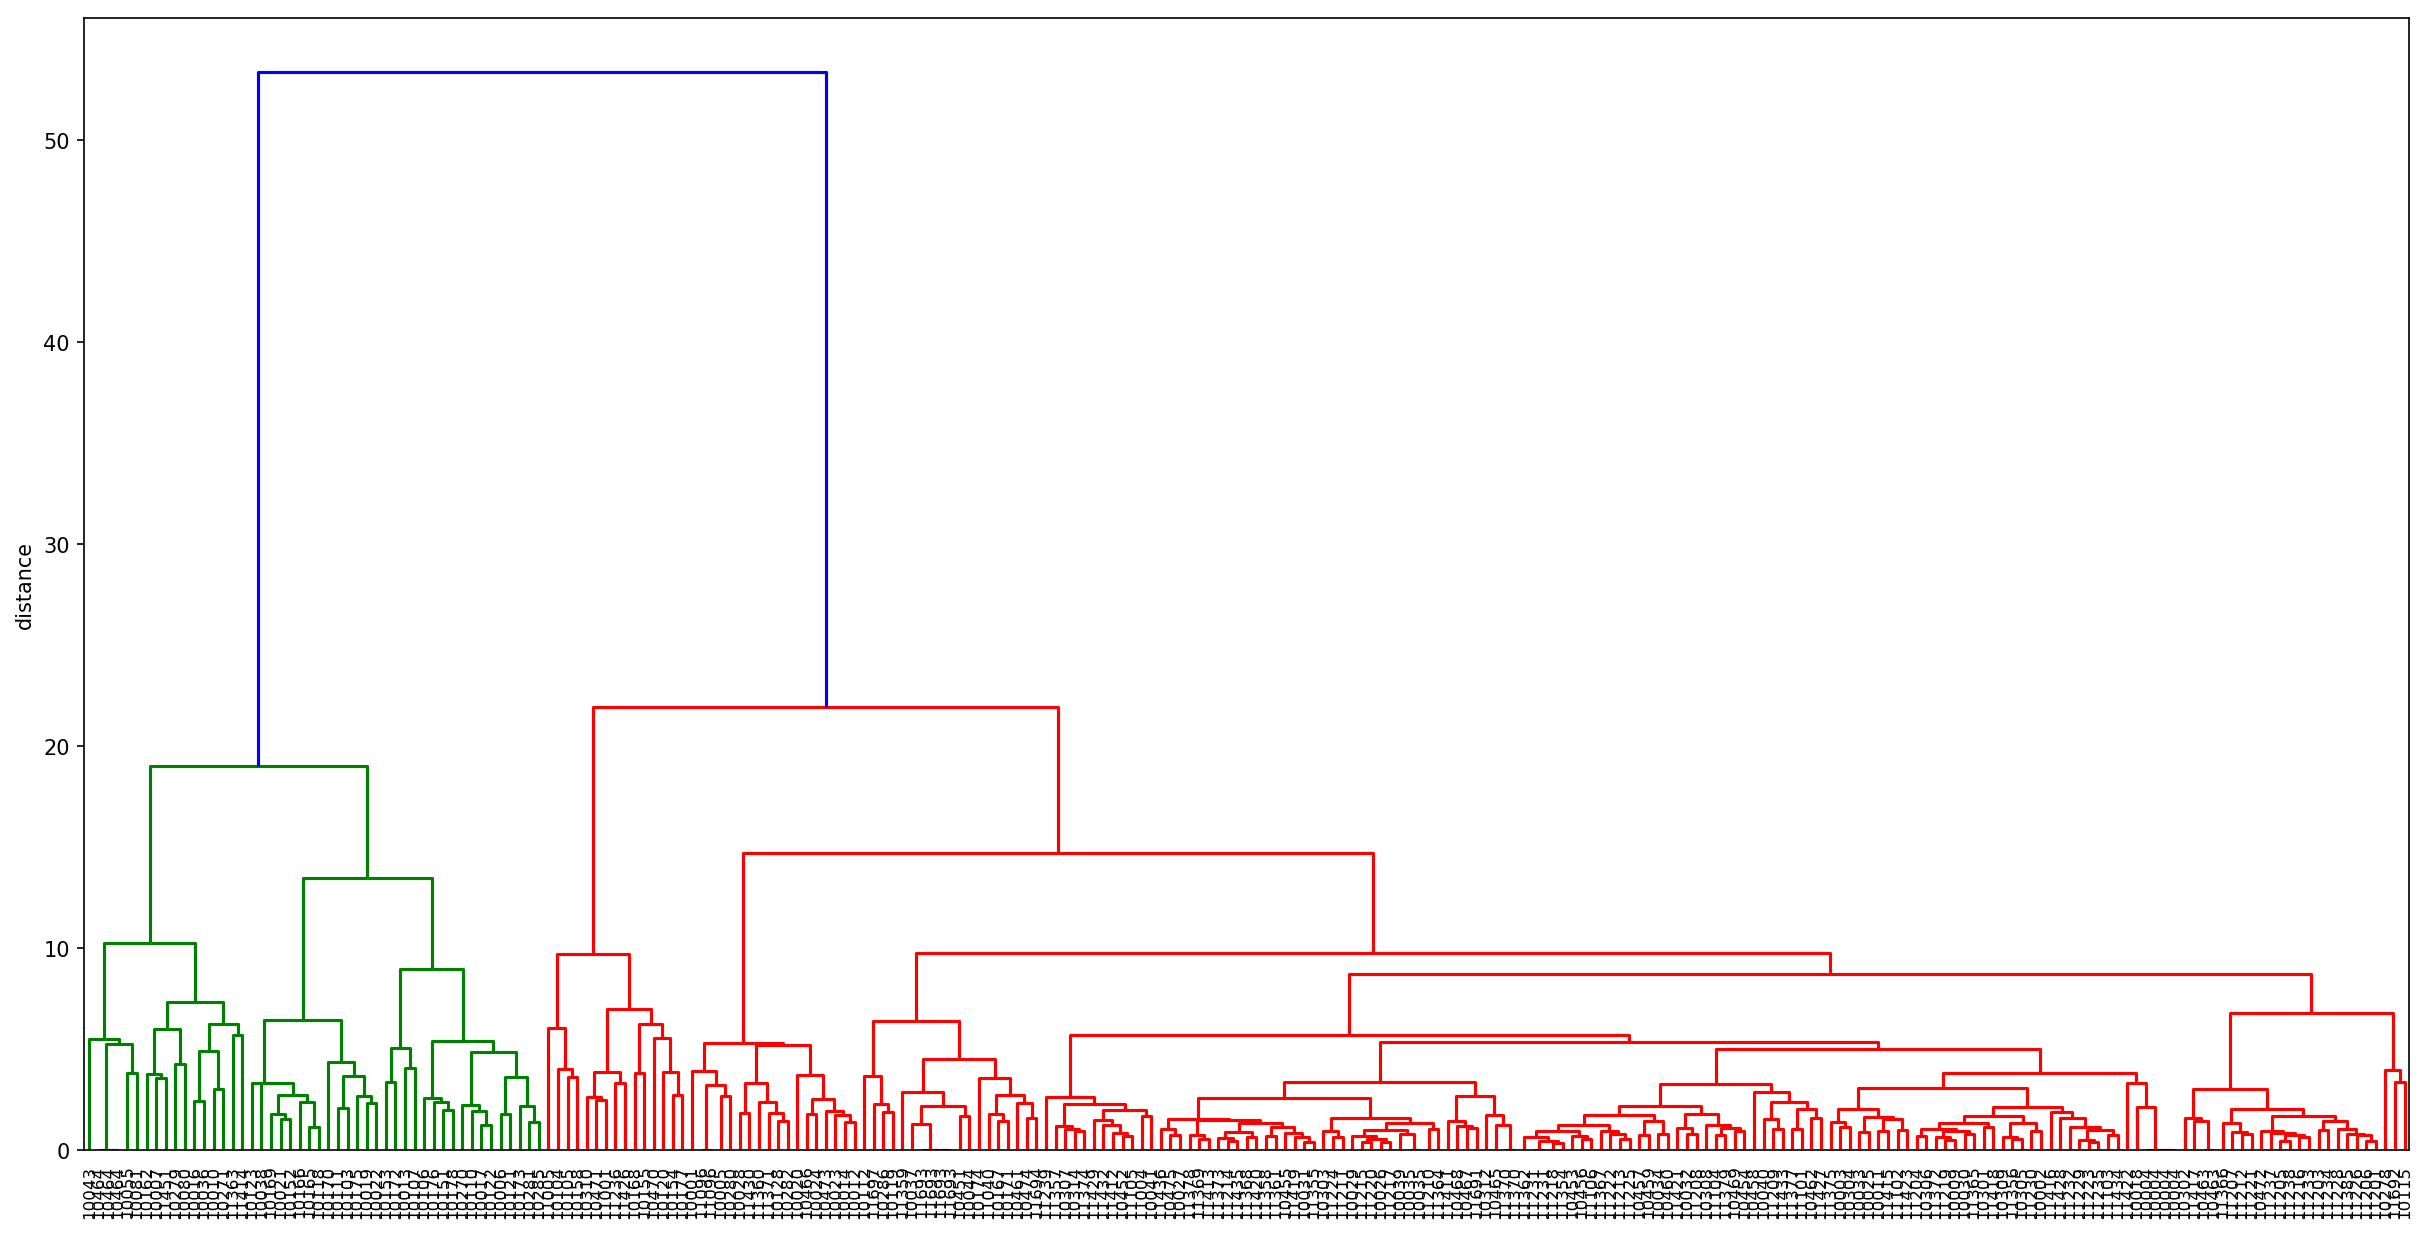

In [338]:
import scipy.cluster as scp
fig = pl.figure(figsize=(20,10), dpi=150)
pl.ylabel("distance")
ddg = scp.hierarchy.dendrogram(scp.hierarchy.linkage(vals, method='ward'),
                               labels = (vals.index),
                               leaf_rotation=90.,  # rotates the x axis labels
                               leaf_font_size=8.)  # font size for the x axis labels)


### Figure 4: The dendrogram of hierarchial clustering of business patterns (number of businesses) at the zipcode level for NYC have been plotted here. The data used here is the yearly Census Buraeu Business data from 1994 to 2014 which is 21 years. The distance(y-axis) shows the distance between any 2 zipcodes. There are too many points(zipcodes) on the x-axis and so, it is very difficult to interpret anything else.

## Task 6

#### Compare the results of kmeans and agglomerative

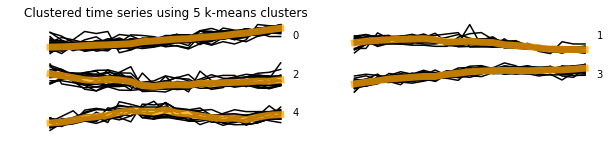

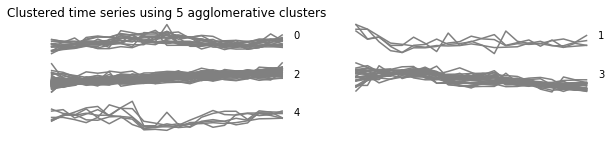

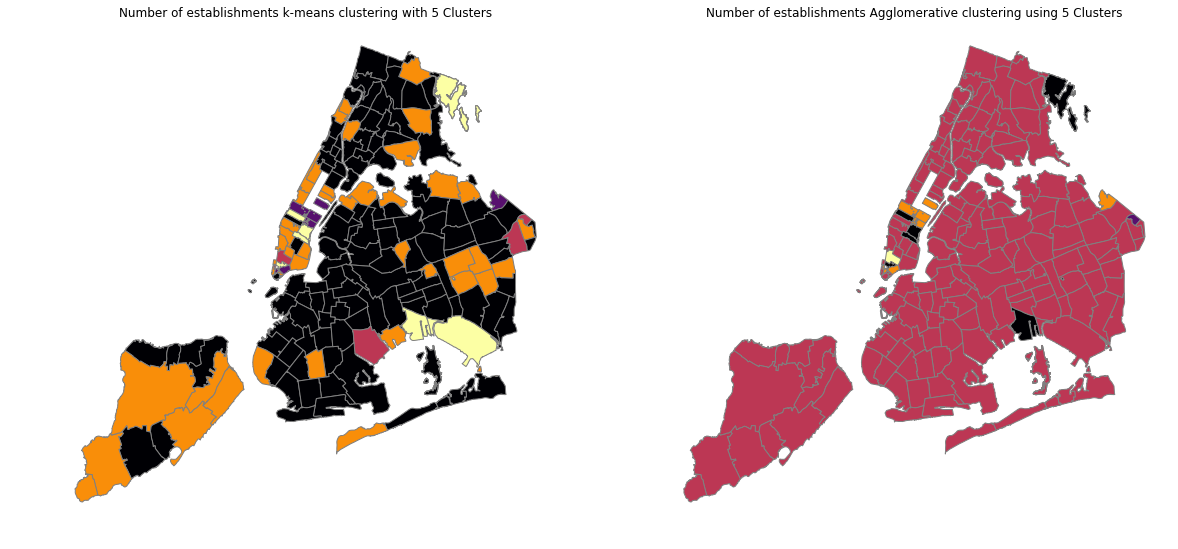

In [449]:
fig = plt.figure(figsize=(10,2))

for i in range(0,5):
    a = vals_clustered_2.loc[vals_clustered_2['labels']==i].iloc[:,:len(vals_clustered_2.columns)-1]
    ax = fig.add_subplot(321+i)
    if i ==0 : ax.set_title('Clustered time series using 5 k-means clusters')
    ax.axis('off')
    ax.annotate('{}'.format(i),xy=(1,1),xytext=(1, 0.5),textcoords='axes fraction')
    for index,row in a.iterrows():
        plt.plot(range(len(vals_clustered_2.columns)-1),row,c='black')
    plt.plot(range(len(vals_clustered_2.columns)-1),centres[i],c='orange',lw=7,alpha=0.75)


fig = plt.figure(figsize=(10,2))
for i in range(0,5):
    a = vals_clustered_agc.loc[vals_clustered_agc['labels']==i].iloc[:,:len(vals_clustered_agc.columns)-1]
    ax = fig.add_subplot(321+i)
    if i ==0 : ax.set_title('Clustered time series using 5 agglomerative clusters')
    ax.axis('off')
    ax.annotate('{}'.format(i),xy=(1,1),xytext=(1, 0.5),textcoords='axes fraction')
    for index,row in a.iterrows():
        plt.plot(range(len(vals_clustered_agc.columns)-1),row,c='grey')
#     plt.plot(range(len(vals_clustered_2.columns)-1),centres[i],c='orange',lw=7,alpha=0.75)
    
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(20,20))
vals_clustered_with_geom_2.plot(column='labels',ax=ax1,  edgecolor='grey',\
                                legend_kwds= {'size': 6}, cmap='inferno')
ax1.set_title('Number of establishments k-means clustering with 5 Clusters')
ax1.axis('off')
# ax.legend(['0','1','2','3'])

#Correct aspect ratio
# ax.axes.set_aspect('equal')

# plt.show()
# fig,ax = plt.subplots(figsize=(10,10))
vals_clustered_with_geom_agc.plot(column='labels',ax=ax2,edgecolor='grey',cmap='inferno')
ax2.set_title('Number of establishments Agglomerative clustering using 5 Clusters')
ax2.axis('off')
# ax.legend(['0','1','2','3'])


#Correct aspect ratio
# ax.axes.set_aspect('equal')

plt.show()

### Figure 5: The above plots show a comparision of k-means clustering and hierarchial clustering for the number of establishments(business patterns) at the zipcode level for NYC. The data used here is the yearly Census Buraeu Business data from 1994 to 2014 which is 21 years. We can see that the kmeans clusters it much better than agglomeative as the latter has almost all the classes in a single cluster and others have very few zipcodes so, the trend is not as obvious in the huge cluster class as for the classes in the k-means clusters. Hence, k-means is the better choice here.

## Task 7